In [1]:
import torchvision
import torch
from torch.utils.data import Subset
import torchvision.transforms.functional as F

transform=torchvision.transforms.Compose([ 
    torchvision.transforms.Lambda(lambda img: F.crop(img, top=2, left=2, height=img.height - 4, width=img.width - 4)),
    torchvision.transforms.Resize((20, 20), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda tensor: (tensor * 10).float())
])

train_dataset = torchvision.datasets.MNIST("data/mnist", download=True, train=True, transform=transform)
test_dataset = torchvision.datasets.MNIST("data/mnist", download=True, train=False, transform=transform)

train_subset = Subset(train_dataset, range(60000))  
test_subset = Subset(train_dataset, range(10000))  
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=2048, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.33MB/s]


In [2]:
G_MAX_P = [45.553, 48.860, 48.911]
G_MAX_D = [20.145, 44.382, 44.382]
G_MIN_P = [1.515,  2.442,  2.317]
G_MIN_D = [1.761,  8.274,  8.374]
AP =  [0.673,  0.204,  0.018] # concern
AD =  [0.107,  0.032,  0.032]
BP =  [-0.597, -0.329, 0.496] # concern
BD =  [3.649,  5.839,  5.839]

In [48]:
import torch 
import torch.nn as nn 

start_p = 2 * 10**-9 # Start at around 15nS
start_d = 2 * 10**-9 
def mysign(x): return (x > 0).float()


def count_sign_difference(tensor1, tensor2):
    # Compute sign of each tensor (-1 for negative, 0 for zero, 1 for positive)
    sign1 = torch.sign(tensor1)
    sign2 = torch.sign(tensor2)
    # Count where the signs differ
    num_different = torch.sum(sign1 != sign2).item()
    return num_different

class MnistClassifier(nn.Module):
    def __init__(self, hidden_dim): 
        super(MnistClassifier, self).__init__()
        self.in_dim = 400
        self.hidden_dim = hidden_dim
        self.out_dim = 10
        
        self.flat = nn.Flatten()
        self.Ron = 5 * (10 ** 6)
        self.act = nn.LeakyReLU(0.1)

        self.alpha_P = 0 
        self.alpha_D = 0 
        self.beta_P = 0 
        self.beta_D = 0 
        self.G_max_p = 0 
        self.G_min_p = 0 
        self.G_max_d = 0 
        self.G_min_d = 0 

        self.update_setup(0)

        self.g_plus_1  = nn.Parameter( torch.rand((self.in_dim,self.hidden_dim ))*(10**-9) + start_p)
        self.g_minus_1 = nn.Parameter(-torch.rand((self.in_dim,self.hidden_dim ))*(10**-9) + start_d)
        self.g_plus_2  = nn.Parameter( torch.rand((self.hidden_dim,self.out_dim))*(10**-9) + start_p)
        self.g_minus_2 = nn.Parameter(-torch.rand((self.hidden_dim,self.out_dim))*(10**-9) + start_d)


    def function_P(self, x): return self.alpha_P * torch.exp(-1*self.beta_P*((x-self.G_min_p)/(self.G_max_p-self.G_min_p)))
    def function_D(self, x): return self.alpha_D * torch.exp(-1*self.beta_D*((self.G_max_d-x)/(self.G_max_d-self.G_min_d)))
    def compute_gradient_P(self, params, deltas): return mysign(deltas) * self.function_P(params)
    def compute_gradient_D(self, params, deltas): return mysign(-deltas) * self.function_D(params)




    
    # CHANGES THE GRANULARITY
    def update_setup(self, I):
        self.G_max_p = G_MAX_P[I] * (10 ** -9)
        self.G_max_d = G_MAX_D[I] * (10 ** -9) 
        self.G_min_p = G_MIN_P[I] * (10 ** -9)
        self.G_min_d = G_MIN_D[I] * (10 ** -9)
        self.alpha_P = AP[I] 
        self.beta_P  = BP[I] 
        self.alpha_D = AD[I] 
        self.beta_D  = BD[I] 
            



    
    # SHIFTS THE PLUS AND MINUS WEIGHTS TO ALLOW FOR MORE CHANGES IN LIGHT OF CLIPPING
    def refresh_func(self, plus_tensor, minus_tensor): 
        clipped_count = 0
        W = (plus_tensor - minus_tensor).clone()
        
        # FOR CORRECTING G_PLUS BEING MAXIMUM 
        mask = (plus_tensor  > self.G_max_p * torch.ones_like(plus_tensor)).int()
        inv_mask = 1 - mask
        with torch.no_grad():
            new_minus = minus_tensor * inv_mask + self.G_min_d * mask
            new_plus = plus_tensor * inv_mask + (W + self.G_min_d) * mask            
            minus_tensor.copy_(new_minus)
            plus_tensor.copy_(new_plus)
        
        # FOR CORRECTING G_MINUS BEING MAXIMUM 
        mask = (minus_tensor > self.G_max_d * torch.ones_like(minus_tensor)).int()
        inv_mask = 1 - mask
        with torch.no_grad():
            new_plus = plus_tensor * inv_mask + self.G_min_p * mask     
            new_minus = minus_tensor * inv_mask + (-W + self.G_min_p) * mask     
            minus_tensor.copy_(new_minus)
            plus_tensor.copy_(new_plus)

        return W 
    




    # SHIFTS WEIGHTS AND CLIP 
    def refresh(self): 
        W1_before = self.refresh_func(self.g_plus_1, self.g_minus_1)
        W2_before = self.refresh_func(self.g_plus_2, self.g_minus_2)

        err1 = torch.norm((self.g_plus_1 - self.g_minus_1) - W1_before).item()
        err2 = torch.norm((self.g_plus_2 - self.g_minus_2) - W2_before).item()
        error = err1 + err2 
        
        with torch.no_grad():  
            self.g_plus_1.data.clamp_( self.G_min_p, self.G_max_p)
            self.g_minus_1.data.clamp_(self.G_min_d, self.G_max_d)
            self.g_plus_2.data.clamp_( self.G_min_p, self.G_max_p)
            self.g_minus_2.data.clamp_(self.G_min_d, self.G_max_d)

        
        # clipped_count = 0 
        # mask = torch.isclose(self.g_plus_1,  self.G_max_p * torch.ones_like(self.g_plus_1), atol=1e-15).int()
        # clipped_count += torch.sum(mask).item()
        # mask = torch.isclose(self.g_minus_1, self.G_max_d * torch.ones_like(self.g_minus_1),  atol=1e-15).int()
        # clipped_count += torch.sum(mask).item()
        # mask = torch.isclose(self.g_plus_2,  self.G_max_p * torch.ones_like(self.g_plus_2), atol=1e-15).int()
        # clipped_count += torch.sum(mask).item()
        # mask = torch.isclose(self.g_minus_2, self.G_max_d * torch.ones_like(self.g_minus_2),  atol=1e-15).int()
        # clipped_count += torch.sum(mask).item()

        clipped_count = 0 
        maskp = torch.isclose(self.g_plus_1,  self.G_max_p * torch.ones_like(self.g_plus_1), atol=1e-15).int()
        maskn = torch.isclose(self.g_minus_1, self.G_max_d * torch.ones_like(self.g_minus_1),  atol=1e-15).int()
        clipped_count += torch.sum(maskp * maskn).item()
        maskp = torch.isclose(self.g_plus_2,  self.G_max_p * torch.ones_like(self.g_plus_2), atol=1e-15).int()
        maskn = torch.isclose(self.g_minus_2, self.G_max_d * torch.ones_like(self.g_minus_2),  atol=1e-15).int()
        clipped_count += torch.sum(maskp * maskn).item()
        
        return clipped_count, error





    # FORWARD PROPAGATION 
    def forward(self, x): 
        x = self.flat(x)
        self.W_1 = self.g_plus_1 - self.g_minus_1
        if(torch.is_grad_enabled()): self.W_1.retain_grad()
        self.h_1 = torch.matmul(x,self.W_1)
        self.y_1 = self.h_1 * self.Ron 

        self.y_1 = self.act(self.y_1)
        self.W_2 = self.g_plus_2 - self.g_minus_2
        if(torch.is_grad_enabled()): self.W_2.retain_grad()
        self.h_2 = torch.matmul(self.y_1,self.W_2)
        self.y_2 = self.h_2 * self.Ron 
        return self.y_2
    



    
    # ANALOG UPDATE RULE 
    def update_parameters(self): 
        measurement1, measurement2, measurement3, measurement4 = 0,0,0,0
        # UPDATE CACLULATION 
        maskit = False
        
        with torch.no_grad():
            ##############################################################################################################
            target_updates1 = -0.05 * self.W_1.grad * torch.norm(self.W_1) / (torch.norm(self.W_1.grad) + 10**-20)
            
            # INCREASING PULSE COUNT FOR P1
            target_updates_P1 = (target_updates1 > 0).int() * target_updates1 
            pseudo_updates_P1 = self.compute_gradient_P(self.g_plus_1.data, target_updates1) * (10 ** -9)
            update_mask = (self.g_minus_1 < self.G_max_d * 0.90).int()
            if(maskit): self.g_plus_1 += update_mask * pseudo_updates_P1
            else: self.g_plus_1 += pseudo_updates_P1

            # INCREASING PULSE COUNT FOR D1
            target_updates_D1 = -1 * (target_updates1 < 0).int() * target_updates1 
            pseudo_updates_D1 = self.compute_gradient_D(self.g_minus_1.data, target_updates1) * (10 ** -9)
            update_mask = (self.g_plus_1 < self.G_max_p * 0.90).int()
            if(maskit): self.g_minus_1 += update_mask * pseudo_updates_D1  
            else: self.g_minus_1 += pseudo_updates_D1
            ##############################################################################################################
            measurement1 = torch.norm(target_updates_P1).item()
            measurement2 = torch.norm(pseudo_updates_P1).item()
            measurement3 = torch.norm(self.g_plus_1).item()
            
            ##############################################################################################################
            target_updates2 = -0.05 * self.W_2.grad * torch.norm(self.W_2) / (torch.norm(self.W_2.grad) + 10**-20)

            # INCREASING PULSE COUNT FOR P1
            target_updates_P2 = (target_updates2 > 0).int() * target_updates2 
            pseudo_updates_P2 = self.compute_gradient_P(self.g_plus_2.data, target_updates2) * (10 ** -9)
            update_mask = (self.g_minus_2 < self.G_max_d * 0.90).int()
            if(maskit): self.g_plus_2 += update_mask * pseudo_updates_P2
            else: self.g_plus_2 +=  pseudo_updates_P2

            # INCREASING PULSE COUNT FOR D1
            target_updates_D2 = -1 *(target_updates2 < 0).int() * target_updates2 
            pseudo_updates_D2 = self.compute_gradient_D(self.g_minus_2.data, target_updates2) * (10 ** -9)
            update_mask = (self.g_plus_2 < self.G_max_p * 0.90).int()
            if(maskit): self.g_minus_2 += update_mask * pseudo_updates_D2
            else: self.g_minus_2 += pseudo_updates_D2
            
            ##############################################################################################################
            measurement4 = count_sign_difference(target_updates_P1, pseudo_updates_P1) + count_sign_difference(target_updates_D1, pseudo_updates_D1) + count_sign_difference(target_updates_P2, pseudo_updates_P2) + count_sign_difference(target_updates_D2, pseudo_updates_D2) 

        clipped, error = self.refresh()
        return measurement1, measurement2, measurement3, measurement4, clipped, error 
    

In [49]:
from tqdm import tqdm 

device = torch.device("cuda")
model = MnistClassifier(50)
model = model.to(device)
model.update_setup(0)
model.refresh()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters())
losses, accuracies = [], []
MEASUREMENT1, MEASUREMENT2, MEASUREMENT3, MEASUREMENT4 = [],[],[],[]
CLIPPED, ERROR = [], []

# BASELINE ACCURACY EVALUATION
total_correct = 0
total_predictions = 0 
model.eval()
with torch.no_grad():
    for test_imgs, test_labels in test_loader: 
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_preds = model(test_imgs)
        predicted = torch.argmax(test_preds, dim=1)
        total_correct += (predicted == test_labels).sum().item()
        total_predictions += test_labels.size(0)
accuracy = total_correct / total_predictions
accuracies.append(accuracy)
model.train()  # Back to training mode


# TRAINING LOOP 
num_epochs = 60
num_batches = len(train_loader)
eval_interval = max(1, num_batches // 2)  # Check every 1/10th of an epoch
for epoch in range(num_epochs):
    
    # if(epoch == 1): model.update_setup(0)
    # model.refresh()
        
    total_loss = 0 
    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader)):
    # for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)

        labels = 5 * torch.nn.functional.one_hot(labels, num_classes=10).float()
        loss = criterion(preds, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        measurement1, measurement2, measurement3, measurement4, clipped, error = model.update_parameters()
        MEASUREMENT1.append(measurement1), MEASUREMENT2.append(measurement2), MEASUREMENT3.append(measurement3), MEASUREMENT4.append(measurement4)
        CLIPPED.append(clipped), ERROR.append(error)

        # Every 1/10th of an epoch, evaluate accuracy
        if (batch_idx + 1) % eval_interval == 0:
            total_correct = 0
            total_predictions = 0 
            model.eval()
            with torch.no_grad():
                for test_imgs, test_labels in test_loader: 
                    test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
                    test_preds = model(test_imgs)
                    predicted = torch.argmax(test_preds, dim=1)
                    total_correct += (predicted == test_labels).sum().item()
                    total_predictions += test_labels.size(0)
            accuracy = total_correct / total_predictions
            accuracies.append(accuracy)
            model.train()  # Back to training mode
        losses.append(loss.item())
            
    print(f"Epoch {epoch}, Loss: {total_loss}, Accuracy: {accuracy}, {accuracies[-10:]}") 
    # losses.append(total_loss)


100%|██████████| 938/938 [00:16<00:00, 56.80it/s]


Epoch 0, Loss: 2539.3415699005127, Accuracy: 0.7976, [0.0978, 0.6799, 0.7976]


100%|██████████| 938/938 [00:16<00:00, 58.58it/s]


Epoch 1, Loss: 31565.18010032177, Accuracy: 0.1014, [0.0978, 0.6799, 0.7976, 0.7618, 0.1014]


100%|██████████| 938/938 [00:16<00:00, 57.40it/s]


Epoch 2, Loss: 65532.126485824585, Accuracy: 0.107, [0.0978, 0.6799, 0.7976, 0.7618, 0.1014, 0.107, 0.107]


100%|██████████| 938/938 [00:16<00:00, 58.03it/s]


Epoch 3, Loss: 51476.74925994873, Accuracy: 0.1014, [0.0978, 0.6799, 0.7976, 0.7618, 0.1014, 0.107, 0.107, 0.1127, 0.1014]


100%|██████████| 938/938 [00:16<00:00, 58.03it/s]


Epoch 4, Loss: 38401.25971508026, Accuracy: 0.1002, [0.6799, 0.7976, 0.7618, 0.1014, 0.107, 0.107, 0.1127, 0.1014, 0.1127, 0.1002]


100%|██████████| 938/938 [00:16<00:00, 58.18it/s]


Epoch 5, Loss: 45696.855425834656, Accuracy: 0.0863, [0.7618, 0.1014, 0.107, 0.107, 0.1127, 0.1014, 0.1127, 0.1002, 0.1032, 0.0863]


 36%|███▌      | 335/938 [00:04<00:08, 71.34it/s]


KeyboardInterrupt: 

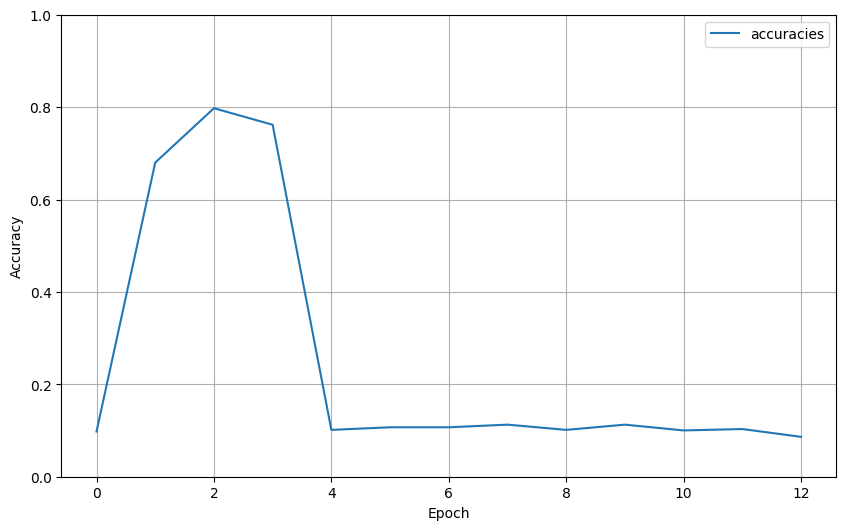

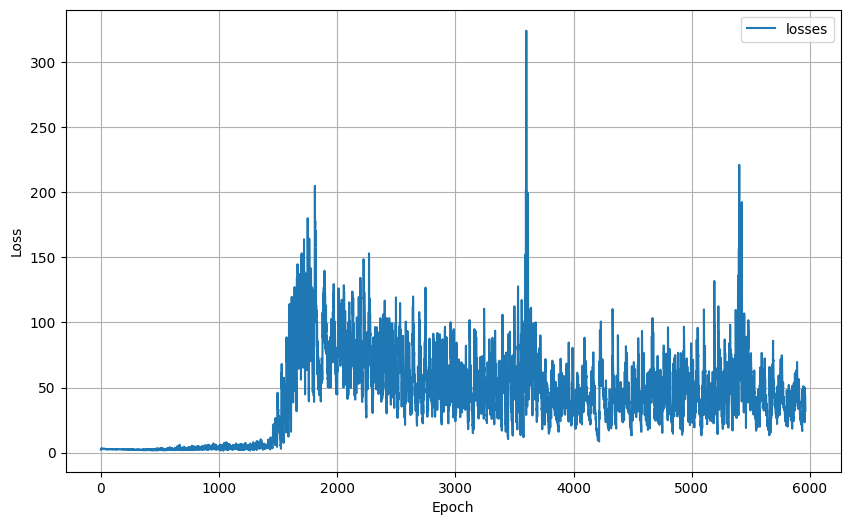

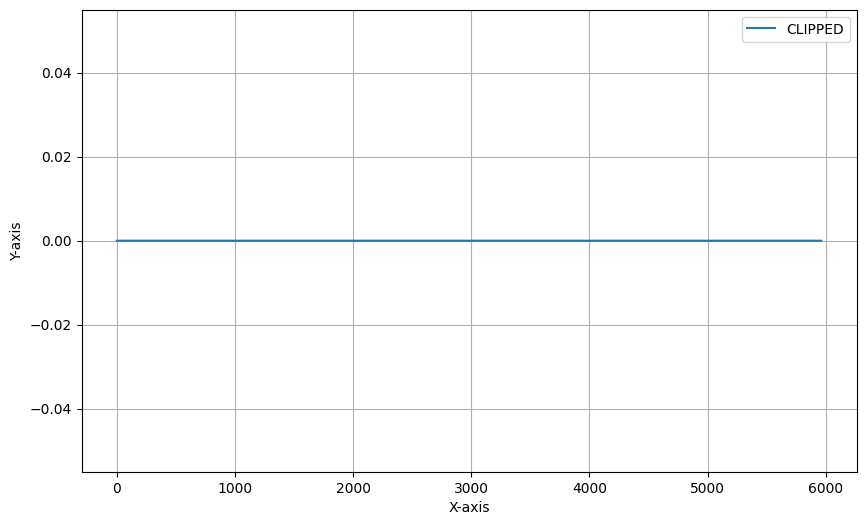

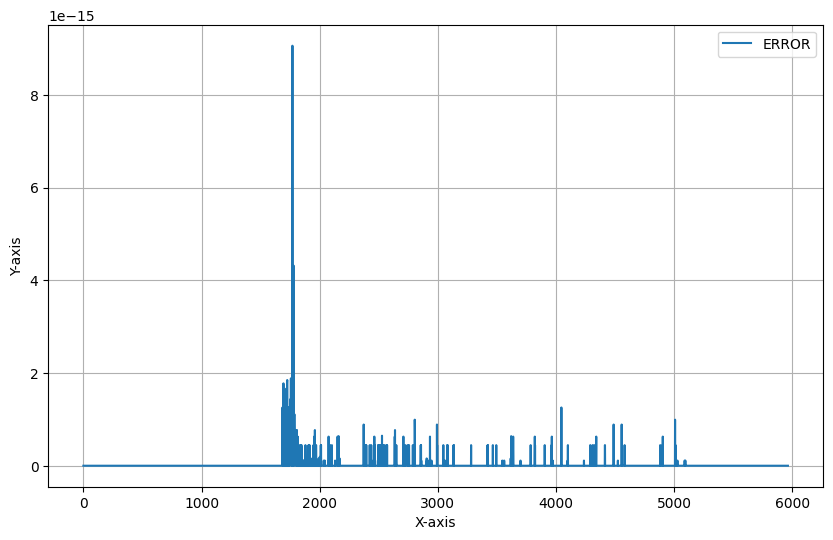

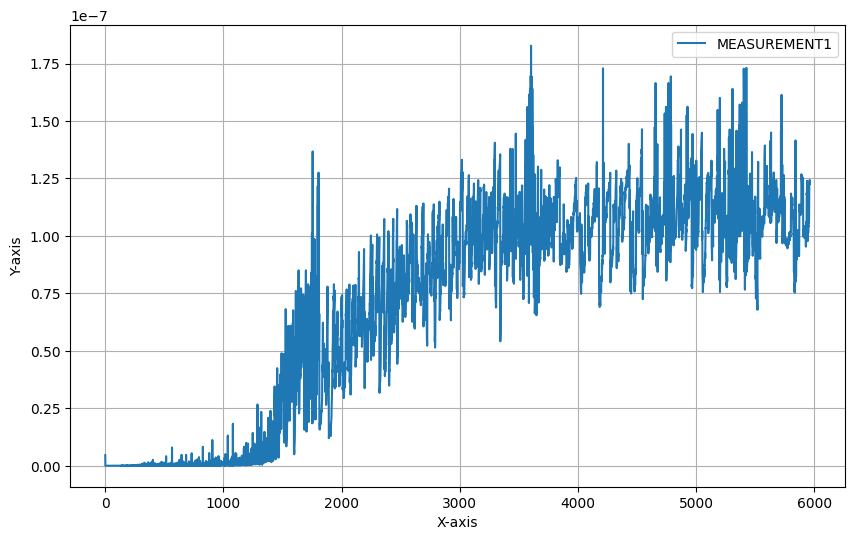

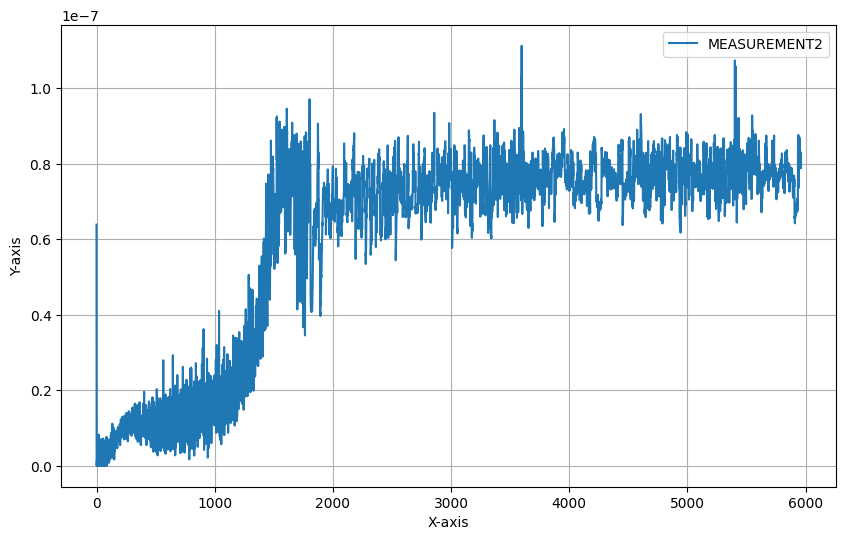

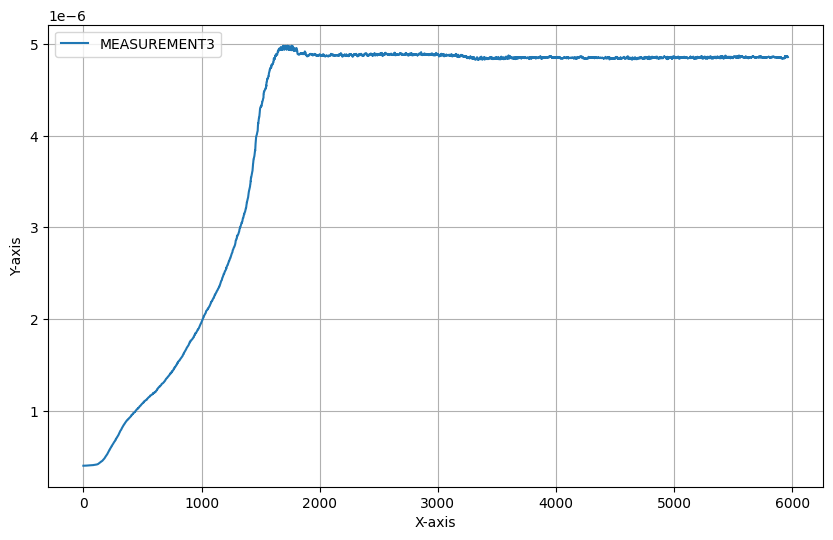

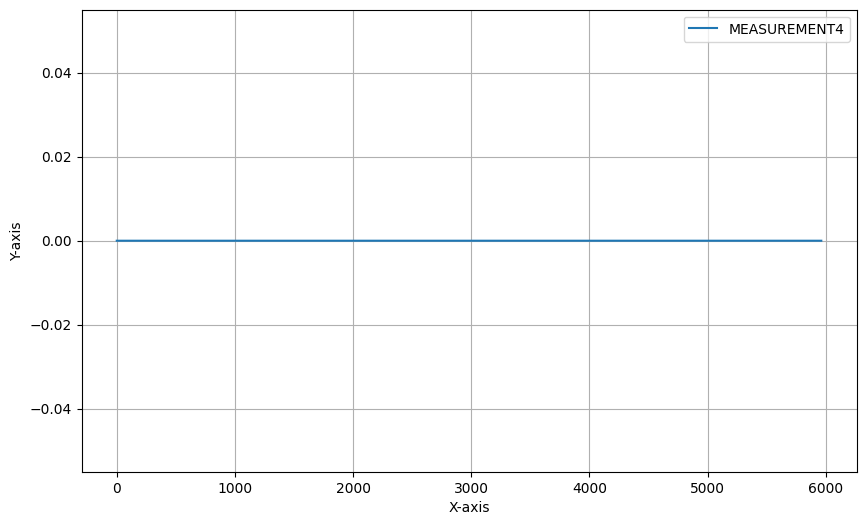

In [50]:

import matplotlib.pyplot as plt

def plot_lists(data, labels=None, title="Plot of Multiple Lists", xlabel="X-axis", ylabel="Y-axis", force=False):
    plt.figure(figsize=(10, 6))
    for i, lst in enumerate(data):
        label = labels[i] if labels and i < len(labels) else f"Series {i+1}"
        plt.plot(lst, label=label)
    if(force): plt.ylim(0,1)
    plt.title("")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()



data = [accuracies]
labels = ["accuracies"]
plot_lists(data, labels, title="Accuracy vs Epoch", xlabel="Epoch", ylabel="Accuracy", force=True)

data = [losses]
labels = ["losses"]
plot_lists(data, labels, title="Loss vs Epoch", xlabel="Epoch", ylabel="Loss")

data = [CLIPPED]
labels = ["CLIPPED"]
plot_lists(data, labels)

data = [ERROR]
labels = ["ERROR"]
plot_lists(data, labels)

data = [MEASUREMENT1]
labels = ["MEASUREMENT1"]
plot_lists(data, labels)

data = [MEASUREMENT2]
labels = ["MEASUREMENT2"]
plot_lists(data, labels)

data = [MEASUREMENT3]
labels = ["MEASUREMENT3"]
plot_lists(data, labels)

data = [MEASUREMENT4]
labels = ["MEASUREMENT4"]
plot_lists(data, labels)


In [ ]:
# model = torch.load("/kaggle/input/mnistclassifier/pytorch/default/1/model_23.pth", weights_only=False)
device = torch.device("cuda")

true_labels = []
predictions = []
with torch.no_grad():
    total_correct = 0
    total_predictions = 0
    for test_imgs, test_labels in test_loader: 
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_preds = model(test_imgs)
        predicted = torch.argmax(test_preds, dim=1)
        total_correct += (predicted == test_labels).sum().item()
        total_predictions += test_labels.size(0)

        true_labels.append(test_labels)
        predictions.append(predicted)
    accuracy = total_correct / total_predictions
print(f"Accuracy: {accuracy}")
true_labels = torch.cat(true_labels)
predictions = torch.cat(predictions)

print(true_labels.shape, predictions.shape)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels, predictions, normalize=False):
    cm = confusion_matrix(labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.show()

plot_confusion_matrix(true_labels.cpu().tolist(), predictions.cpu().tolist())